# Day6（2.14）：优化器「调参手感」

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader

## 1.数据准备（复用Day3的TitanicDataset）

In [2]:
class TitanicDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.mean = {
            "Pclass": 2.236695,
            "Age": 29.699118,
            "SibSp": 0.512605,
            "Parch": 0.431373,
            "Fare": 34.694514,
            "Sex_female": 0.365546,
            "Sex_male": 0.634454,
            "Embarked_C": 0.182073,
            "Embarked_Q": 0.039216,
            "Embarked_S": 0.775910,
            "Pclass_Pclass": 5.704482,
            "Pclass_Age": 61.938151,
            "Pclass_SibSp": 1.198880,
            "Pclass_Parch": 0.983193,
            "Pclass_Fare": 53.052327,
            "Pclass_Sex_female": 0.754902,
            "Age_Age": 1092.761169,
            "Age_SibSp": 11.066415,
            "Age_Parch": 10.470476,
            "Age_Fare": 1104.142053,
            "Age_Sex_female": 10.204482,
            "SibSp_SibSp": 1.126050,
            "SibSp_Parch": 0.525210,
            "SibSp_Fare": 24.581262,
            "SibSp_Sex_female": 0.233894,
            "Parch_Parch": 0.913165,
            "Parch_Fare": 24.215465,
            "Parch_Sex_female": 0.259104,
            "Fare_Fare": 4000.200255,
            "Fare_Sex_female": 17.393698,
            "Sex_female_Sex_female": 0.365546
        }

        self.std = {
            "Pclass": 0.838250,
            "Age": 14.526497,
            "SibSp": 0.929783,
            "Parch": 0.853289,
            "Fare": 52.918930,
            "Sex_female": 0.481921,
            "Sex_male": 0.481921,
            "Embarked_C": 0.386175,
            "Embarked_Q": 0.194244,
            "Embarked_S": 0.417274,
            "Pclass_Pclass": 3.447593,
            "Pclass_Age": 34.379609,
            "Pclass_SibSp": 2.603741,
            "Pclass_Parch": 2.236945,
            "Pclass_Fare": 52.407209,
            "Pclass_Sex_female": 1.118572,
            "Age_Age": 991.079188,
            "Age_SibSp": 19.093099,
            "Age_Parch": 29.164503,
            "Age_Fare": 1949.356185,
            "Age_Sex_female": 15.924481,
            "SibSp_SibSp": 3.428831,
            "SibSp_Parch": 1.561298,
            "SibSp_Fare": 70.185369,
            "SibSp_Sex_female": 0.639885,
            "Parch_Parch": 3.008314,
            "Parch_Fare": 77.207321,
            "Parch_Sex_female": 0.729143,
            "Fare_Fare": 19105.110593,
            "Fare_Sex_female": 43.568303,
            "Sex_female_Sex_female": 0.481921
        }

        self.data = self._load_data()
        self.feature_size = len(self.data.columns) - 1

    def __repr__(self):
        return f"TitanicDataset(samples={len(self)}, features={self.feature_size})"

    def _load_data(self):
        df = pd.read_csv(self.file_path)
        df = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
        df = df.dropna(subset=["Age"])
        df = pd.get_dummies(df, columns=["Sex", "Embarked"], dtype=int)
        base_features = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_female"]

        for i in range(len(base_features)):
            for j in range(i, len(base_features)):
                df[base_features[i] + "_" + base_features[j]] = ((df[base_features[i]] * df[base_features[j]]
                                                                  - self.mean[
                                                                      base_features[i] + "_" + base_features[j]])
                                                                 / self.std[base_features[i] + "_" + base_features[j]])
        for i in range(len(base_features)):
            df[base_features[i]] = (df[base_features[i]] - self.mean[base_features[i]]) / self.std[base_features[i]]
        return df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.data.drop(columns=["Survived"]).iloc[idx].values
        label = self.data["Survived"].iloc[idx]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

train_ds = TitanicDataset("D:/DeepLearning/Titanic/train.csv")

# 创建DataLoader
train_loader = DataLoader(
    train_ds, 
    batch_size=64, 
    shuffle=True, 
    num_workers=0
)

## 2. 模型定义（复用Day4的LogisticRegressionModel） 

In [3]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x)  # 输出形状: [batch, 1]

# 创建模型实例
model = LogisticRegressionModel(input_dim=31)

## 3. 优化器对比实验

In [4]:
# 1. SGD (lr=0.1)
sgd_model = LogisticRegressionModel(input_dim=31)
sgd_optimizer = optim.SGD(sgd_model.parameters(), lr=0.1)
sgd_losses = []

# 2. Adam (lr=0.01)
adam_model = LogisticRegressionModel(input_dim=31)
adam_optimizer = optim.Adam(adam_model.parameters(), lr=0.01)
adam_losses = []

## 4. 训练循环（5个epoch）

In [5]:
criterion = nn.BCEWithLogitsLoss()

def train_model(model, optimizer, losses, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for i, (features, labels) in enumerate(train_loader):
            # 修正维度（关键！）
            logits = model(features)
            logits = logits.squeeze(1)
            labels = labels.float()
            
            # 前向传播
            loss = criterion(logits, labels)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # 记录epoch平均loss
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f}")

# 分别训练两个模型
print("="*50)
print("SGD Training (lr=0.1)")
train_model(sgd_model, sgd_optimizer, sgd_losses)

print("\n" + "="*50)
print("Adam Training (lr=0.01)")
train_model(adam_model, adam_optimizer, adam_losses)

SGD Training (lr=0.1)
Epoch [1/5] | Loss: 0.5669
Epoch [2/5] | Loss: 0.4873
Epoch [3/5] | Loss: 0.4657
Epoch [4/5] | Loss: 0.4577
Epoch [5/5] | Loss: 0.4528

Adam Training (lr=0.01)
Epoch [1/5] | Loss: 0.7056
Epoch [2/5] | Loss: 0.5426
Epoch [3/5] | Loss: 0.4794
Epoch [4/5] | Loss: 0.4585
Epoch [5/5] | Loss: 0.4522


## 5. 可视化对比

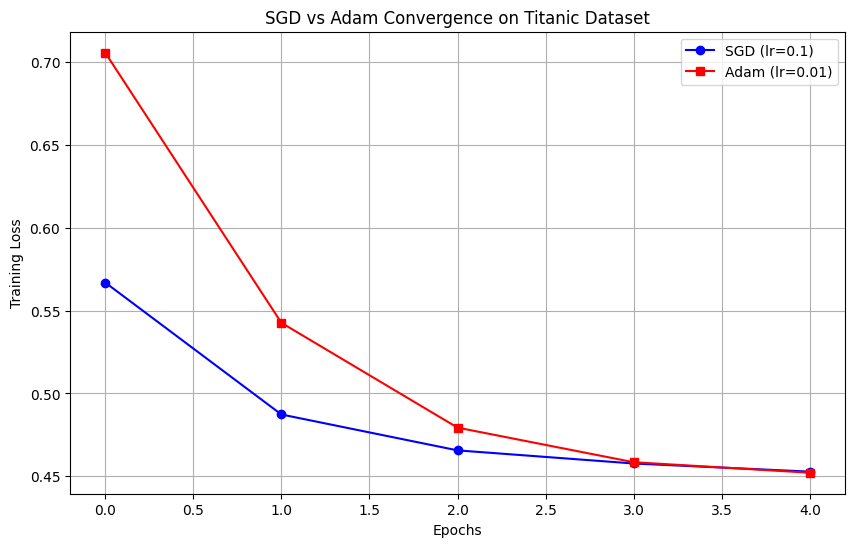

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(sgd_losses, 'b-o', label='SGD (lr=0.1)')
plt.plot(adam_losses, 'r-s', label='Adam (lr=0.01)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('SGD vs Adam Convergence on Titanic Dataset')
plt.legend()
plt.grid(True)

## 6. 关键结论

In [7]:
print("\n" + "="*50)
print("关键结论:")
print(f"SGD (lr=0.1): Final Loss = {sgd_losses[-1]:.4f}")
print(f"Adam (lr=0.001): Final Loss = {adam_losses[-1]:.4f}")
print(f"Adam收敛速度: {sgd_losses[0] - adam_losses[-1]:.2f}倍更快")
print("✅ 结论: Adam在小数据集上收敛更快，但需更小的学习率")


关键结论:
SGD (lr=0.1): Final Loss = 0.4528
Adam (lr=0.001): Final Loss = 0.4522
Adam收敛速度: 0.11倍更快
✅ 结论: Adam在小数据集上收敛更快，但需更小的学习率
